## 📊 Dataset Overview
- Total Samples: 20,000
- Class Imbalance: 90% real reviews (majority), 10% fake reviews (minority)
- Source: Generated using ChatGPT
- Imbalance Strategy: This version leverages a Weighted Random Sampler to ensure minority class representation in every training batch.

### 🧮 What is a Weighted Random Sampler?
The Weighted Random Sampler is a sampling technique used during training to give higher probability to minority class samples. Key aspects of its behavior:

- Batch Composition: Ensures that each training batch includes more balanced class representation, favoring inclusion of minority samples.
- Sampling with Replacement: Samples are drawn with replacement, meaning the same minority sample can appear in multiple batches—helping reinforce learning from underrepresented examples.
- Requires Custom Trainer: To use a weighted sampler in the training process, a custom Trainer setup is required instead of the default Hugging Face training loop.

### 🧠 Model Architecture
- Model Used: bert-base-cased from Hugging Face Transformers
- Training Loop: Modified with a custom Trainer to integrate the weighted random sampler
- Goal: Increase minority class exposure during training without modifying the dataset itself

### 📈 Evaluation Metrics
Model performance is assessed using multiple evaluation techniques:
- Confusion Matrix
- Accuracy (used for reference only; not suitable for imbalanced data)
- Precision
- Recall
- F1 Score
- ROC Curve
- PR (Precision-Recall) Curve

⚠️ Note: As with prior notebooks, the PR Curve is considered more appropriate than the ROC Curve for imbalanced classification tasks. Weighted sampling helps train the model to better detect fake reviews by reinforcing rare class patterns.

## Import Libraries

In [ ]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.4/491.4 kB 14.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 19.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 14.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 21.9 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system 

In [ ]:
!pip install evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 4.7 MB/s eta 0:00:00


In [ ]:
import torch
from torch.utils.data import DataLoader, WeightedRandomSampler
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from datasets import load_dataset, Dataset, DatasetDict
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import LabelEncoder
import numpy as np
from collections import Counter
import pandas as pd
from google.colab import files
import io
from transformers import DataCollatorWithPadding

## Import Dataset, Then split and convert to DataDict

In [ ]:
# Step 1: Upload a file from your local machine
uploaded = files.upload()

# Step 2: Read the uploaded file into a pandas DataFrame
# Assuming the uploaded file is a CSV
for filename in uploaded.keys():
    print(f"Reading file: {filename}")
    df = pd.read_csv(io.BytesIO(uploaded[filename]))
    break  # Only read the first file uploaded

# Step 3: Display the first few rows of the DataFrame
df.head()

Saving Combined_Real_vs_Fake_Reviews_Dataset__20_000_Samples_.csv to Combined_Real_vs_Fake_Reviews_Dataset__20_000_Samples_ (1).csv
Reading file: Combined_Real_vs_Fake_Reviews_Dataset__20_000_Samples_ (1).csv


,text,label
0,I can't stop recommending this to everyone I k...,0
1,I can't stop recommending this to everyone I k...,0
2,Absolutely amazing! I would buy this again and...,0
3,Exceeded my expectations. Perfect in every way...,0
4,"Unbelievable performance, can't live without i...",0


In [ ]:
df['label'].value_counts()

,count
label,
0,18000
1,2000


In [ ]:
df.rename(columns={'label': 'labels'}, inplace=True)
df.head()

,text,labels
0,I can't stop recommending this to everyone I k...,0
1,I can't stop recommending this to everyone I k...,0
2,Absolutely amazing! I would buy this again and...,0
3,Exceeded my expectations. Perfect in every way...,0
4,"Unbelievable performance, can't live without i...",0


In [ ]:
import numpy as np
train, validate, test = np.split(df.sample(frac=1, random_state=42),[int(.6*len(df)),int(.8*len(df))])

/usr/local/lib/python3.11/dist-packages/numpy/_core/fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [ ]:
train = train.reset_index()[['text','labels']]
validate = validate.reset_index()[['text','labels']]
test = test.reset_index()[['text','labels']]

In [ ]:
tds = Dataset.from_pandas(train)
vds = Dataset.from_pandas(validate)
teds = Dataset.from_pandas(test)

In [ ]:
dataset = DatasetDict()
dataset["train"] = tds
dataset["validate"] = vds
dataset["test"] = teds

In [ ]:
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'labels'],
        num_rows: 12000
    })
    validate: Dataset({
        features: ['text', 'labels'],
        num_rows: 4000
    })
    test: Dataset({
        features: ['text', 'labels'],
        num_rows: 4000
    })
})

In [ ]:
# Check the number of records after over sampling
label_counts = Counter(dataset["train"]["labels"])
print(sorted(label_counts.items()))

[(0, 10806), (1, 1194)]


## Tokenizer

In [ ]:
num_labels = len(set(dataset['train']['labels']))

# Load tokenizer and tokenize the dataset
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
def tokenize(batch):
    return tokenizer(batch["text"], padding="max_length", truncation=True, max_length=128)

tokenized = dataset.map(tokenize, batched=True)
tokenized.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

Map:   0%|          | 0/12000 [00:00<?, ? examples/s]

Map:   0%|          | 0/4000 [00:00<?, ? examples/s]

Map:   0%|          | 0/4000 [00:00<?, ? examples/s]

In [ ]:
train_dataset = tokenized["train"]
eval_dataset = tokenized["validate"]
test_dataset = tokenized['test']

## Weighted Random Sampler Model Building

In [ ]:
y_train = [int(example["labels"]) for example in train_dataset]
class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(y_train), y=y_train)
sample_weights = [class_weights[label] for label in y_train]
sampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)

train_dataloader = DataLoader(train_dataset, sampler=sampler, batch_size=16)

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=num_labels)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
num_labels

2

## Compute Metrics

In [ ]:
import evaluate
import numpy as np

# Load required metrics
accuracy_metric = evaluate.load("accuracy")
precision_metric = evaluate.load("precision")
recall_metric = evaluate.load("recall")
f1_metric = evaluate.load("f1")

# Define compute_metrics using evaluate
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)

    # Compute individual metrics
    accuracy = accuracy_metric.compute(predictions=predictions, references=labels)
    macro_precision = precision_metric.compute(predictions=predictions, references=labels, average="macro")
    macro_recall = recall_metric.compute(predictions=predictions, references=labels, average="macro")
    macro_f1 = f1_metric.compute(predictions=predictions, references=labels, average="macro")

    weighted_precision = precision_metric.compute(predictions=predictions, references=labels, average="weighted")
    weighted_recall = recall_metric.compute(predictions=predictions, references=labels, average="weighted")
    weighted_f1 = f1_metric.compute(predictions=predictions, references=labels, average="weighted")

    # Combine all into one dictionary
    return {
        "accuracy": accuracy["accuracy"],
        "macro_precision": macro_precision["precision"],
        "macro_recall": macro_recall["recall"],
        "macro_f1": macro_f1["f1"],
        "weighted_precision": weighted_precision["precision"],
        "weighted_recall": weighted_recall["recall"],
        "weighted_f1": weighted_f1["f1"]
    }

## Training Arguments for Custom Trainer

In [ ]:
# ✅ TrainingArguments
args = TrainingArguments(
    output_dir="results",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="macro_f1",
    greater_is_better=True,
    report_to="none",
)

In [ ]:
from torch.utils.data import DataLoader

# Custom Trainer to override the dataloader with our WeightedRandomSampler
class CustomTrainer(Trainer):
    def get_train_dataloader(self):
        return DataLoader(
            self.train_dataset,
            sampler=sampler,  # This uses your WeightedRandomSampler
            batch_size=self.args.train_batch_size,
            collate_fn=self.data_collator,
        )

trainer = CustomTrainer(
    model=model,
    args=args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    data_collator=data_collator,
)


<ipython-input-66-d7b793dcd369>:13: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `CustomTrainer.__init__`. Use `processing_class` instead.
  trainer = CustomTrainer(


## Train Model

In [ ]:
# Train
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,Macro Precision,Macro Recall,Macro F1,Weighted Precision,Weighted Recall,Weighted F1
1,0.546300,0.487861,0.815750,0.604218,0.679505,0.621652,0.875586,0.815750,0.839800
2,0.426400,0.471615,0.804750,0.595916,0.672267,0.610991,0.873099,0.804750,0.831998
3,0.339600,0.503626,0.800500,0.590813,0.664195,0.604468,0.870743,0.800500,0.828624


TrainOutput(global_step=2250, training_loss=0.43742816840277776, metrics={'train_runtime': 917.6771, 'train_samples_per_second': 39.229, 'train_steps_per_second': 2.452, 'total_flos': 2367999498240000.0, 'train_loss': 0.43742816840277776, 'epoch': 3.0})

In [ ]:
trainer.state.best_model_checkpoint

'results/checkpoint-750'

## Evaluate Model

In [ ]:
trainer.evaluate()

{'eval_loss': 0.4878605902194977,
 'eval_accuracy': 0.81575,
 'eval_macro_precision': 0.6042175692532913,
 'eval_macro_recall': 0.6795049364301442,
 'eval_macro_f1': 0.6216523192725663,
 'eval_weighted_precision': 0.8755858668646068,
 'eval_weighted_recall': 0.81575,
 'eval_weighted_f1': 0.8398004979609909,
 'eval_runtime': 32.001,
 'eval_samples_per_second': 124.996,
 'eval_steps_per_second': 7.812,
 'epoch': 3.0}

In [ ]:
12000/16

750.0

In [ ]:
750 * 3

2250

In [ ]:
test_metrics = trainer.evaluate(eval_dataset= test_dataset)
print(test_metrics)

{'eval_loss': 0.4497271776199341, 'eval_accuracy': 0.81925, 'eval_macro_precision': 0.6138046374368681, 'eval_macro_recall': 0.6824025583791209, 'eval_macro_f1': 0.6320793711152537, 'eval_weighted_precision': 0.8702470758135433, 'eval_weighted_recall': 0.81925, 'eval_weighted_f1': 0.8399155268484735, 'eval_runtime': 30.5855, 'eval_samples_per_second': 130.781, 'eval_steps_per_second': 8.174, 'epoch': 3.0}


In [ ]:
trainer.predict(test_dataset)

PredictionOutput(predictions=array([[10.640857 ,  9.743893 , -3.078512 , ..., -2.6412196, -3.0987298,
        -3.2284858],
       [10.916405 ,  8.059992 , -2.751698 , ..., -2.5075006, -2.8961713,
        -3.2426198],
       [10.103831 , 10.551008 , -3.0745363, ..., -2.7410643, -3.1363578,
        -3.084357 ],
       ...,
       [10.503202 , 10.633855 , -3.0543847, ..., -2.7650657, -3.150833 ,
        -3.0655987],
       [10.577404 ,  9.551123 , -3.027131 , ..., -2.7278934, -3.1299968,
        -3.3071907],
       [ 8.935593 , 11.211004 , -2.9676833, ..., -2.660688 , -2.9074776,
        -2.8236892]], dtype=float32), label_ids=array([0, 0, 0, ..., 0, 0, 0]), metrics={'test_loss': 0.4497271776199341, 'test_accuracy': 0.81925, 'test_macro_precision': 0.6138046374368681, 'test_macro_recall': 0.6824025583791209, 'test_macro_f1': 0.6320793711152537, 'test_weighted_precision': 0.8702470758135433, 'test_weighted_recall': 0.81925, 'test_weighted_f1': 0.8399155268484735, 'test_runtime': 31.5545, '

## ROC Curve

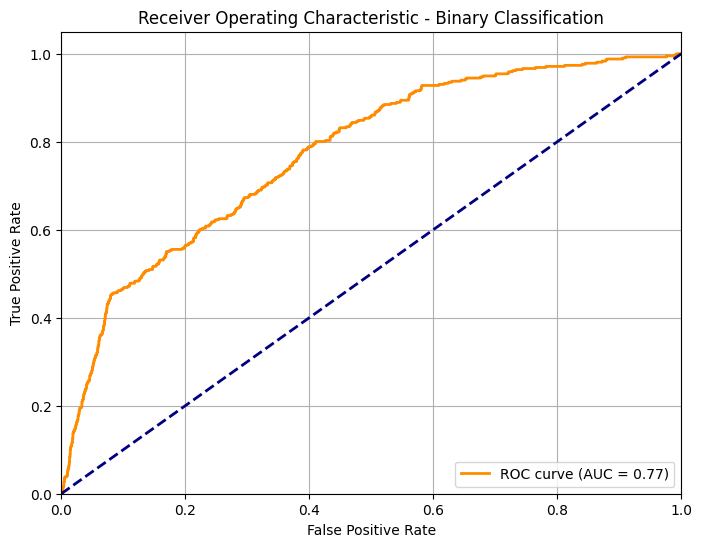

X-Axis: False Positive Rate (FPR) = FP / FP+TN
Y-Axis: True Positive Rate (TPR) (also called Recall or Sensitivity) = TP / TP+FN


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

predictions = trainer.predict(test_dataset)

logits = predictions.predictions
label_ids = predictions.label_ids

# Step 1: Apply softmax to convert logits to probabilities
from scipy.special import softmax
probs = softmax(logits, axis=1)
positive_class_probs = probs[:, 1]  # probability of class 1

# Step 2: Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(predictions.label_ids, positive_class_probs)
roc_auc = auc(fpr, tpr)

# Step 3: Plot the ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic - Binary Classification')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

print("-----------------------------------------------------------------------------------------")
print("X-Axis: False Positive Rate (FPR) = FP / FP+TN")
print("Y-Axis: True Positive Rate (TPR) (also called Recall or Sensitivity) = TP / TP+FN")

## Precision-Recall Curve

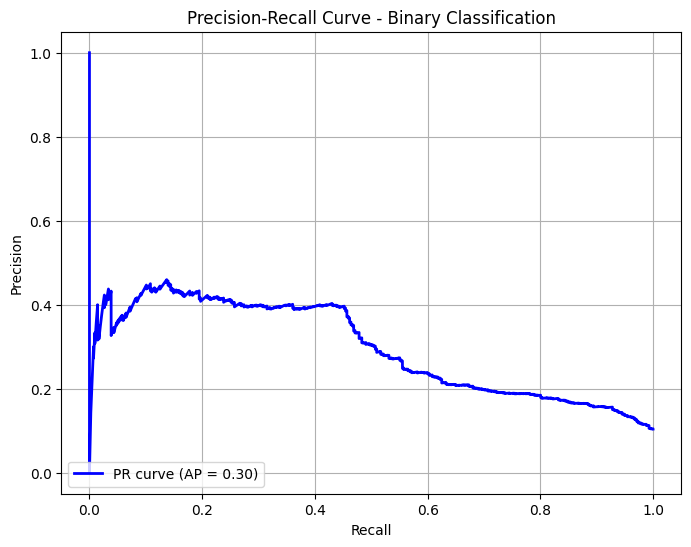

-----------------------------------------------------------------------------------------
X-Axis: True Positive Rate (TPR) (also called Recall or Sensitivity) = TP / TP+FN
Y-Axis: Precision = TP / TP+FP

Precision and Recall at different thresholds:
Threshold: 0.1 | Precision: 0.16, Recall: 0.92
Threshold: 0.2 | Precision: 0.20, Recall: 0.70
Threshold: 0.3 | Precision: 0.24, Recall: 0.59
Threshold: 0.4 | Precision: 0.27, Recall: 0.55
Threshold: 0.5 | Precision: 0.29, Recall: 0.51
Threshold: 0.6 | Precision: 0.33, Recall: 0.47
Threshold: 0.7 | Precision: 0.38, Recall: 0.46
Threshold: 0.8 | Precision: 0.39, Recall: 0.45
Threshold: 0.9 | Precision: 0.43, Recall: 0.19


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, average_precision_score

# Step 1: Apply softmax to convert logits to probabilities
from scipy.special import softmax
probs = softmax(logits, axis=1)
positive_class_probs = probs[:, 1]  # Probability of class 1 (positive class)

# Step 2: Compute Precision-Recall curve and Average Precision (AP)
precision, recall, thresholds = precision_recall_curve(label_ids, positive_class_probs)
average_precision = average_precision_score(label_ids, positive_class_probs)

# Step 3: Plot the Precision-Recall Curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='b', lw=2, label=f'PR curve (AP = {average_precision:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve - Binary Classification')
plt.legend(loc="lower left")
plt.grid(True)
plt.show()

print("-----------------------------------------------------------------------------------------")
print("X-Axis: True Positive Rate (TPR) (also called Recall or Sensitivity) = TP / TP+FN")
print("Y-Axis: Precision = TP / TP+FP")

print("\nPrecision and Recall at different thresholds:")
for t in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]:
    idx = np.argmax(thresholds >= t)
    if idx < len(precision):
        print(f"Threshold: {t:.1f} | Precision: {precision[idx]:.2f}, Recall: {recall[idx]:.2f}")

## F1 vs Threshold Curve

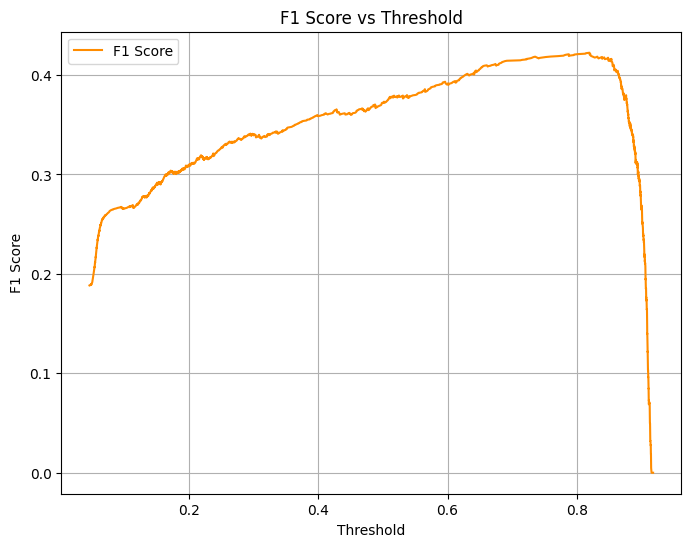


Best F1 = 0.42 at threshold ≈ 0.82


In [ ]:
# Step 5: Plot F1 score vs threshold
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-8)

plt.figure(figsize=(8, 6))
plt.plot(thresholds, f1_scores[:-1], label="F1 Score", color='darkorange')
plt.xlabel("Threshold")
plt.ylabel("F1 Score")
plt.title("F1 Score vs Threshold")
plt.grid(True)
plt.legend()
plt.show()

# Step 6: Best F1 and corresponding threshold
best_idx = np.argmax(f1_scores[:-1])  # exclude final point which has no threshold
print(f"\nBest F1 = {f1_scores[best_idx]:.2f} at threshold ≈ {thresholds[best_idx]:.2f}")

## Confusion matrix

In [ ]:
test_dataset["labels"]

tensor([0, 0, 0,  ..., 0, 0, 0])

In [ ]:
from collections import Counter

# Convert each label tensor to a plain integer
labels = [int(label) for label in test_dataset["labels"]]

# Now count them
label_counts = Counter(labels)

# Print the results nicely
print(label_counts)

Counter({0: 3584, 1: 416})


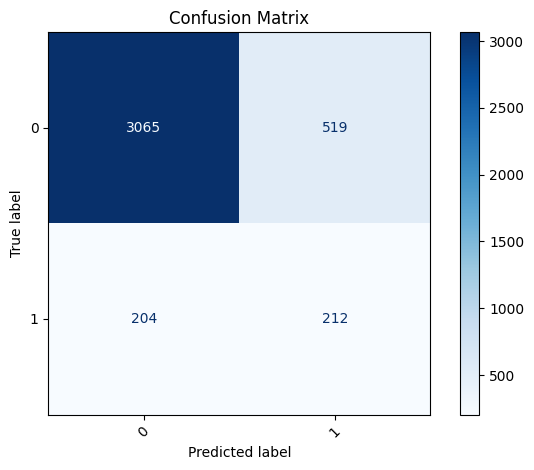


=== Evaluation Metrics ===
Accuracy:- Out of all the predictions we made, How many were True.
TP+TN / TP+TN+FP+FN
Accuracy:  0.8193
-----------------------------------------------
Precision:- Out of all the positive predictions we made, How many were True?
TP / TP+FP
Precision: 0.2900
-----------------------------------------------
Recall:- Out of all the data points that should be predicted as True, How many we correctly predict as True?
TP / TP+FN
Recall:    0.5096
-----------------------------------------------
F1 Score:- Harmonic mean of Precision and Recall
2 * (Precision * Recall) / (Precision + Recall)
F1 Score:  0.3697
-----------------------------------------------
Specificity:- Out of all the negative predictions we made, How many were True?
TN / TN+FP
Specificity: 0.8552
-----------------------------------------------
False Positive Rate:- Out of all the negative data points that should be predicted as False, How many we incorrectly predict as True?
FP / FP+TN
False Positiv

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# 1. Run prediction on the test set (or validation set)
predictions_output = trainer.predict(test_dataset)  # or dataset["validation"]

# 2. Get predicted labels and true labels
y_true = predictions_output.label_ids
y_pred = np.argmax(predictions_output.predictions, axis=1)

# 3. Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# 4. Optional: Get class names from label encoder if you have one
try:
    class_names = label_encoder.classes_
except:
    class_names = [str(i) for i in np.unique(y_true)]

# 5. Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

# Unpack confusion matrix
tn, fp, fn, tp = cm.ravel()

# 6. Compute all evaluation metrics (no 'average' needed!)
accuracy_metric = evaluate.load("accuracy")
precision_metric = evaluate.load("precision")
recall_metric = evaluate.load("recall")
f1_metric = evaluate.load("f1")
specificity = tn / (tn + fp)
false_positive_rate = fp / (fp + tn)
false_negative_rate = fn / (fn + tp)
npv = tn / (tn + fn)

accuracy = accuracy_metric.compute(predictions=y_pred, references=y_true)
precision = precision_metric.compute(predictions=y_pred, references=y_true)
recall = recall_metric.compute(predictions=y_pred, references=y_true)
f1 = f1_metric.compute(predictions=y_pred, references=y_true)

# 7. Print metrics
print("\n=== Evaluation Metrics ===")
print("Accuracy:- Out of all the predictions we made, How many were True.")
print("TP+TN / TP+TN+FP+FN")
print(f"Accuracy:  {accuracy['accuracy']:.4f}")
print("-----------------------------------------------")
print("Precision:- Out of all the positive predictions we made, How many were True?")
print("TP / TP+FP")
print(f"Precision: {precision['precision']:.4f}")
print("-----------------------------------------------")
print("Recall:- Out of all the data points that should be predicted as True, How many we correctly predict as True?")
print("TP / TP+FN")
print(f"Recall:    {recall['recall']:.4f}")
print("-----------------------------------------------")
print("F1 Score:- Harmonic mean of Precision and Recall")
print("2 * (Precision * Recall) / (Precision + Recall)")
print(f"F1 Score:  {f1['f1']:.4f}")
print("-----------------------------------------------")
print("Specificity:- Out of all the negative predictions we made, How many were True?")
print("TN / TN+FP")
print(f"Specificity: {specificity:.4f}")
print("-----------------------------------------------")
print("False Positive Rate:- Out of all the negative data points that should be predicted as False, How many we incorrectly predict as True?")
print("FP / FP+TN")
print(f"False Positive Rate: {false_positive_rate:.4f}")
print("-----------------------------------------------")
print("False Negative Rate:- Out of all the positive data points that should be predicted as True, How many we incorrectly predict as False?")
print("FN / FN+TP")
print(f"False Negative Rate: {false_negative_rate:.4f}")
print("-----------------------------------------------")
print("Negative Predictive Value:- Out of all the negative predictions we made, How many were True?")
print("TN / TN+FN")
print(f"Negative Predictive Value: {npv:.4f}")
print("===============================================")


In [ ]:
import numpy as np
from IPython.display import display, Markdown

# Get the original texts (assumes dataset["test"] is a Hugging Face Dataset)
texts = dataset["test"]["text"]  # Change to the correct field name if it's not "text"

# Categorize indices into TP, TN, FP, FN
tp_indices = [i for i in range(len(y_true)) if y_true[i] == 1 and y_pred[i] == 1]
tn_indices = [i for i in range(len(y_true)) if y_true[i] == 0 and y_pred[i] == 0]
fp_indices = [i for i in range(len(y_true)) if y_true[i] == 0 and y_pred[i] == 1]
fn_indices = [i for i in range(len(y_true)) if y_true[i] == 1 and y_pred[i] == 0]

# Display a few examples for each case
def show_examples(indices, label):
    display(Markdown(f"### 🔍 {label} Examples"))
    for i in indices[:3]:  # Show top 3 examples
        text = texts[i]
        true_label = y_true[i]
        pred_label = y_pred[i]
        display(Markdown(f"**Text:** {text}\n\n- **True Label:** {true_label}\n- **Predicted Label:** {pred_label}\n---"))

# Show them
show_examples(tp_indices, "True Positives")
show_examples(tn_indices, "True Negatives")
show_examples(fp_indices, "False Positives")
show_examples(fn_indices, "False Negatives")

### 🔍 True Positives Examples

**Text:** Truly the best purchase I've made this year. Bought via Jones, Burns and Kramer.

- **True Label:** 1
- **Predicted Label:** 1
---

**Text:** Top-notch item, highly recommend it to all. Bought via Wolf-Hamilton.

- **True Label:** 1
- **Predicted Label:** 1
---

**Text:** Outstanding product! Can't recommend it enough. Bought via Kim-Valentine.

- **True Label:** 1
- **Predicted Label:** 1
---

### 🔍 True Negatives Examples

**Text:** Amazing quality and superb value! Bought from Thompson-Wilson.

- **True Label:** 0
- **Predicted Label:** 0
---

**Text:** Quality control could be better. Purchased from Martin, Oconnor and Wilson on 2025-01-07.

- **True Label:** 0
- **Predicted Label:** 0
---

**Text:** Absolutely amazing! I would buy this again and again! Bought from Mcmahon, Hill and Taylor.

- **True Label:** 0
- **Predicted Label:** 0
---

### 🔍 False Positives Examples

**Text:** Unbelievable performance, can't live without it! Bought from Sparks, Jones and Smith.

- **True Label:** 0
- **Predicted Label:** 1
---

**Text:** Excellent item. Five stars without a doubt! Bought from Howard, Simon and Mccarthy.

- **True Label:** 0
- **Predicted Label:** 1
---

**Text:** Highly satisfied! Amazing features and quality. Bought via Flores, Parker and Reilly.

- **True Label:** 0
- **Predicted Label:** 1
---

### 🔍 False Negatives Examples

**Text:** Works fine, though battery life could be better. Purchased on 2025-01-23.

- **True Label:** 1
- **Predicted Label:** 0
---

**Text:** Mediocre quality, acceptable for the cost. Purchased from Jackson-Miller on 2025-01-20.

- **True Label:** 1
- **Predicted Label:** 0
---

**Text:** Unbelievable performance, can't live without it! Bought from Carter-Bowman.

- **True Label:** 1
- **Predicted Label:** 0
---